                  user_id             business_id  \
0  AGNUgVwnZUey3gcPCJ76iw  3uLgwr0qeCNMjKenHJwPGQ   
1  NBN4MgHP9D3cw--SnauTkA  QoezRbYQncpRqyrLH6Iqjg   
2  -copOvldyKh1qr-vzkDEvw  MYoRNLb5chwjQe3c_k37Gg   
3  FjMQVZjSqY8syIO-53KFKw  hV-bABTK-glh5wj31ps_Jw   
4  ld0AperBXk1h6UbqmM80zw  _uN0OudeJ3Zl_tf6nxg5ww   

                                                text                 date  \
0                     Avengers time with the ladies.  2012-05-18 02:17:21   
1  They have lots of good deserts and tasty cuban...  2013-02-05 18:35:10   
2             It's open even when you think it isn't  2013-08-18 00:56:08   
3                          Very decent fried chicken  2017-06-27 23:05:38   
4             Appetizers.. platter special for lunch  2012-10-06 19:43:09   

   compliment_count name address city state postal_code  latitude  longitude  \
0               0.0  NaN     NaN  NaN   NaN         NaN       NaN        NaN   
1               0.0  NaN     NaN  NaN   NaN         NaN   

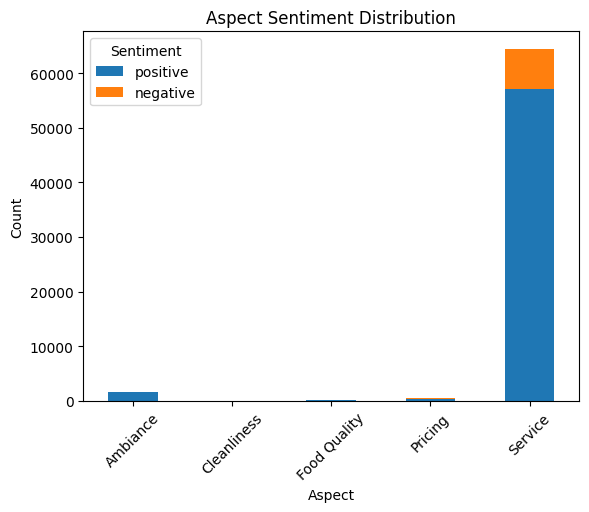

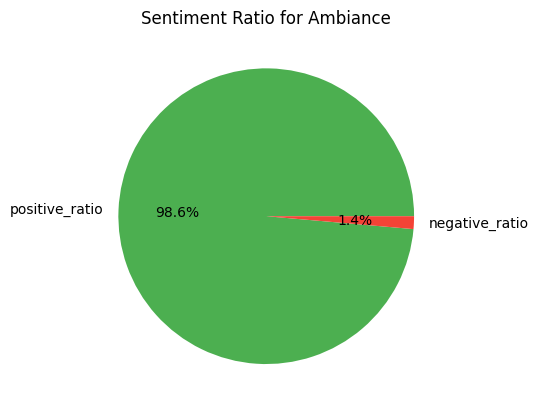

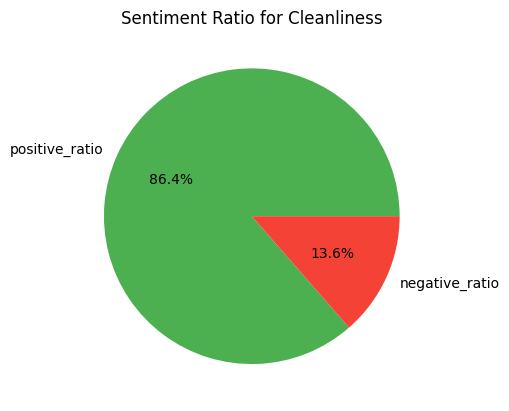

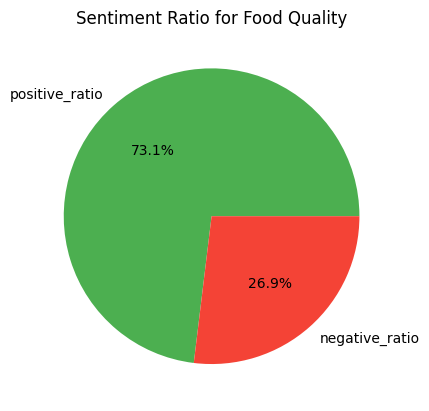

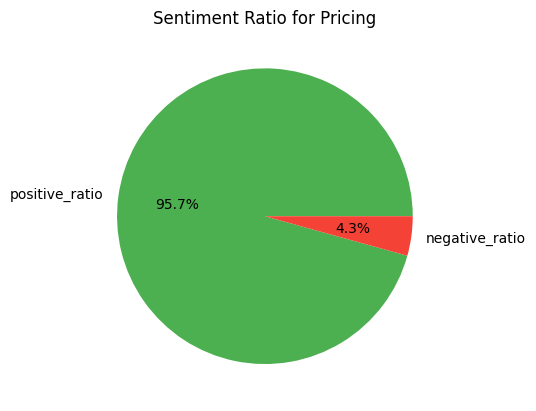

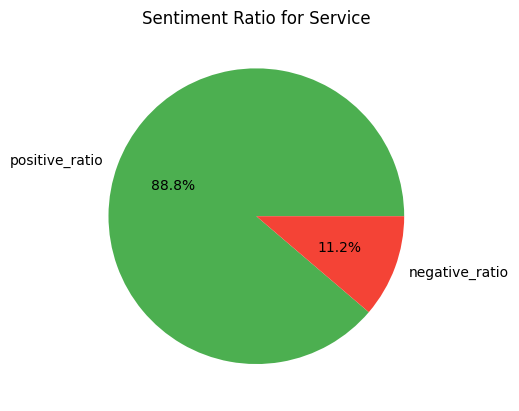

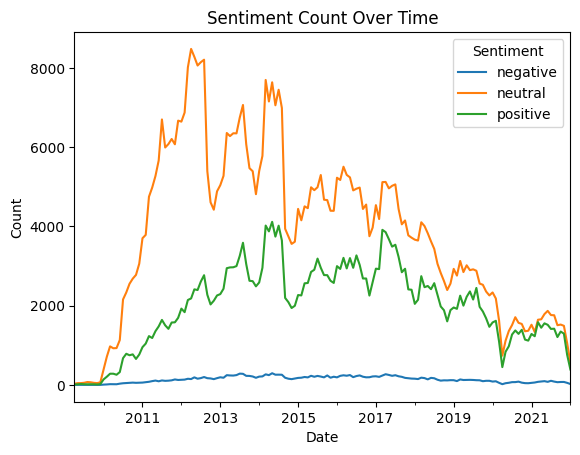

In [14]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Ensure nltk data is available
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Paths to the JSON files
json_file_paths = [
    '/content/yelp_academic_dataset_tip.json',  # Original file
    '/content/yelp_academic_dataset_checkin.json',              # Additional file 1
    '/content/yelp_academic_dataset_business.json'               # Additional file 2
]

# Step 2: Reading and merging the JSON files
dfs = [pd.read_json(file_path, lines=True) for file_path in json_file_paths]
df = pd.concat(dfs, ignore_index=True)

# Print the structure of the dataset
print(df.head())

# Check the column names
print(df.columns)

# Step 3: Aspect extraction with handling for non-string values
def extract_aspects(text, aspects):
    if not isinstance(text, str):  # Ensure text is a string
        return []  # Return an empty list if the text is not a valid string

    extracted_aspects = []
    for aspect in aspects:
        if aspect.lower() in text.lower():
            extracted_aspects.append(aspect)
    return extracted_aspects

aspects = ['Food Quality', 'Service', 'Ambiance', 'Pricing', 'Cleanliness']

# Use the correct column name 'text'
df['extracted_aspects'] = df['text'].apply(lambda x: extract_aspects(str(x), aspects))

# Step 4: Basic rule-based sentiment classification
positive_words = ['great', 'amazing', 'good', 'excellent', 'positive', 'love']
negative_words = ['slow', 'bad', 'terrible', 'poor', 'negative', 'hate', 'expensive']

def classify_sentiment(text):
    if not isinstance(text, str):  # Ensure text is a string
        return 'neutral'  # Return neutral if the text is not a valid string

    text = text.lower()
    if any(word in text for word in positive_words):
        return 'positive'
    elif any(word in text for word in negative_words):
        return 'negative'
    else:
        return 'neutral'

# Use the correct column name 'text'
df['sentiment_classification'] = df['text'].apply(classify_sentiment)

# Step 5: Evaluation
# Assuming you have actual sentiment labels for comparison (replace 'sentiment' if needed)
y_true = df['sentiment'] if 'sentiment' in df.columns else None
y_pred = df['sentiment_classification']

if y_true is not None:
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=['positive', 'neutral', 'negative'])

    # Plot confusion matrix with matplotlib
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')

    # Show all ticks and label them
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    ax.set_xticklabels(['positive', 'neutral', 'negative'])
    ax.set_yticklabels(['positive', 'neutral', 'negative'])

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    for i in range(3):
        for j in range(3):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.show()

# Step 6: Generate Insights
aspect_sentiment_summary = df.explode('extracted_aspects').groupby('extracted_aspects')['sentiment_classification'].value_counts().unstack().fillna(0)
aspect_sentiment_summary['total'] = aspect_sentiment_summary.sum(axis=1)
aspect_sentiment_summary['positive_ratio'] = aspect_sentiment_summary['positive'] / aspect_sentiment_summary['total']
aspect_sentiment_summary['negative_ratio'] = aspect_sentiment_summary['negative'] / aspect_sentiment_summary['total']

print("Aspect Sentiment Summary:")
print(aspect_sentiment_summary)

# Step 7: Generate Insights
insights = {
    'positive': aspect_sentiment_summary['positive_ratio'].idxmax(),
    'negative': aspect_sentiment_summary['negative_ratio'].idxmax()
}

print("Insights:")
print(f"Aspect with most positive sentiment: {insights['positive']}")
print(f"Aspect with most negative sentiment: {insights['negative']}")

# Detailed Graphs

# Aspect Sentiment Distribution Bar Chart
aspect_sentiment_distribution = aspect_sentiment_summary[['positive', 'negative']]
aspect_sentiment_distribution.plot(kind='bar', stacked=True)
plt.title('Aspect Sentiment Distribution')
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

# Aspect Sentiment Ratio Pie Chart
for aspect in aspect_sentiment_summary.index:
    data = aspect_sentiment_summary.loc[aspect, ['positive_ratio', 'negative_ratio']]
    plt.figure()
    data.plot(kind='pie', autopct='%1.1f%%', colors=['#4CAF50', '#F44336'])
    plt.title(f'Sentiment Ratio for {aspect}')
    plt.ylabel('')
    plt.show()

# Sentiment Count Over Time (if 'date' column exists)
if 'date' in df.columns:
    try:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Convert to datetime, set invalid parsing as NaT
        df.dropna(subset=['date'], inplace=True)  # Drop rows where date parsing failed
        df.set_index('date', inplace=True)
        sentiment_over_time = df.resample('M')['sentiment_classification'].value_counts().unstack().fillna(0)

        sentiment_over_time.plot(kind='line')
        plt.title('Sentiment Count Over Time')
        plt.xlabel('Date')
        plt.ylabel('Count')
        plt.legend(title='Sentiment')
        plt.show()
    except Exception as e:
        print(f"Error processing dates: {e}")